# Aprendizado de Máquina em Séries Temporais

### Modelo SARIMA para predição de temperaturas de SST - Sea Surface Temperature Forecasting

- Gildo
- Maiser Alves: 6309717
- Victal
- Vítor Fróis: 12543440

### Introdução

Modelos SARIMA são modelos da classe de modelos univariados de séries temporais. O acrônimo SARIMA significa modelos AutoRegressivos Integrados de Médias Móveis com Sazonalidade. São modelos bastante úteis para gerar previsão de séries temporais quando, em geral, não estão disponíveis variáveis preditoras. O aspecto mais interessante desse tipo de abordagem é justamente colocar a parte sazonal da série dentro do modelo. [Referência](https://analisemacro.com.br/economia/comentario-de-conjuntura/modelos-sarima/)

In [6]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from common.utils import mape
import math
import warnings
warnings.filterwarnings("ignore")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Carrengando o dataset e tratando os dados e colunas não úteis

In [10]:
fp = '../data/sst.mnmean.nc'
ds = nc.Dataset(fp)

In [11]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [12]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # garante que há apenas uma medição por área por tempo
df = df.drop('nbnds', axis='columns') # remove coluna nbnds
df = df.drop('time_bnds', axis='columns') # remove coluna time_bnds

In [13]:
print("Latitudes", df['lat'].unique())
print("Longitudes", df['lon'].unique())

Latitudes [ 88.  86.  84.  82.  80.  78.  76.  74.  72.  70.  68.  66.  64.  62.
  60.  58.  56.  54.  52.  50.  48.  46.  44.  42.  40.  38.  36.  34.
  32.  30.  28.  26.  24.  22.  20.  18.  16.  14.  12.  10.   8.   6.
   4.   2.   0.  -2.  -4.  -6.  -8. -10. -12. -14. -16. -18. -20. -22.
 -24. -26. -28. -30. -32. -34. -36. -38. -40. -42. -44. -46. -48. -50.
 -52. -54. -56. -58. -60. -62. -64. -66. -68. -70. -72. -74. -76. -78.
 -80. -82. -84. -86. -88.]
Longitudes [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206

In [14]:
df.head()

,lat,lon,time,sst
0,88.0,0.0,1854-01-01,-1.8
2,88.0,0.0,1854-02-01,-1.8
4,88.0,0.0,1854-03-01,-1.8
6,88.0,0.0,1854-04-01,-1.8
8,88.0,0.0,1854-05-01,-1.8


### Funções úteis

In [15]:
# setando column_name como índice do dataframe
def set_dataframe_index(df: pd.DataFrame, column_name: str):
    return df.set_index(column_name)

def get_date_and_temperature_from(df: pd.DataFrame, lat: int, lon: int):
    return df[(df['lat'] == lat) & (df['lon'] == lon)]

f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [16]:
#setando a culuna tempo como índice do dataframe
df = set_dataframe_index(df, 'time')
df.head()

,lat,lon,sst
time,,,
1854-01-01,88.0,0.0,-1.8
1854-02-01,88.0,0.0,-1.8
1854-03-01,88.0,0.0,-1.8
1854-04-01,88.0,0.0,-1.8
1854-05-01,88.0,0.0,-1.8


### Pegando a temperatura de um ponto no dataset

In [17]:
df_sst_lat_lon = get_date_and_temperature_from(df, 32.0, 16.0)

# os pontos definidos de latitude e longitude
# lat = 20°, lon = -132°
#df_sst_enso = get_date_and_temperature_from(df, f_inv(20.0), f_inv(-132.0))

# lat = -22°, lon = -72°
#df_sst_chile = get_date_and_temperature_from(df, f_inv(-22.0), f_inv(-72.0))

# lat = 36°, lon = 18°
#df_sst_medit = get_date_and_temperature_from(df, f_inv(36.0), f_inv(18.0))

# lat = 0°, lon = -22°
#df_sst_atlantico = get_date_and_temperature_from(df, f_inv(0.0), f_inv(-22.0))

# lat = -56°, lon = 80°
#df_sst_indico = get_date_and_temperature_from(df, f_inv(-56.0), f_inv(80.0))


In [18]:
df_sst_lat_lon.head()

,lat,lon,sst
time,,,
1854-01-01,32.0,16.0,17.333422
1854-02-01,32.0,16.0,16.721617
1854-03-01,32.0,16.0,16.491089
1854-04-01,32.0,16.0,17.444820
1854-05-01,32.0,16.0,19.150229


### Plotando a temperatura de um ponto do dataset através do tempo

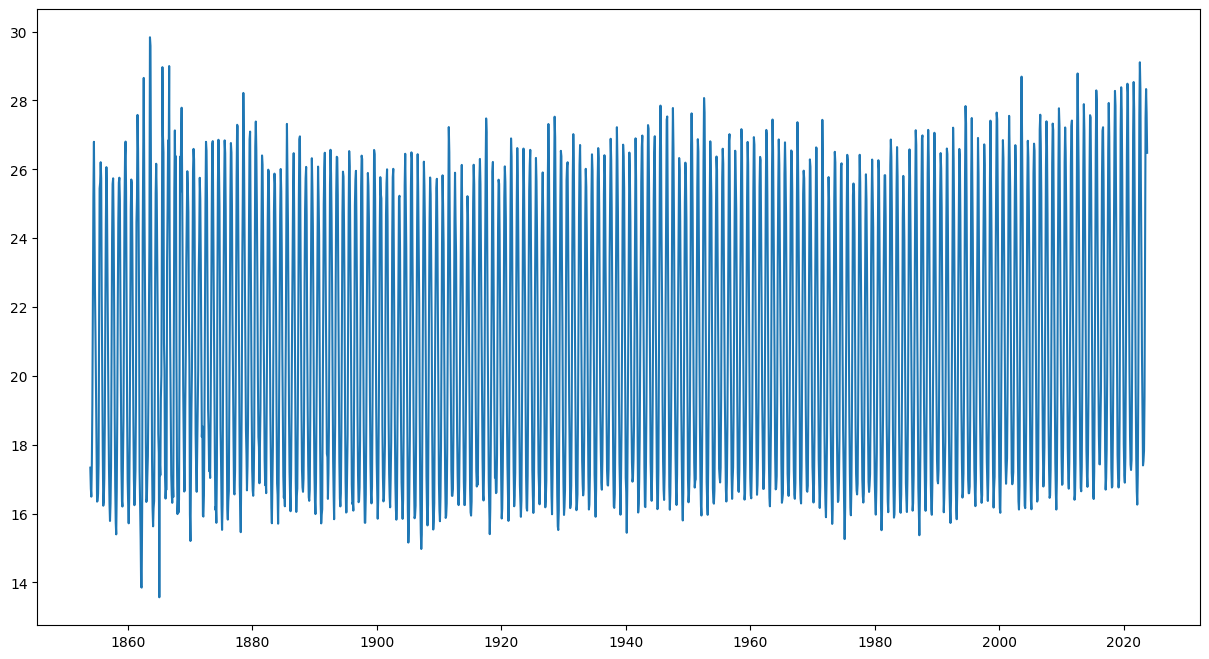

In [19]:
index = df_sst_lat_lon.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index,df_sst_lat_lon['sst'])
plt.show()

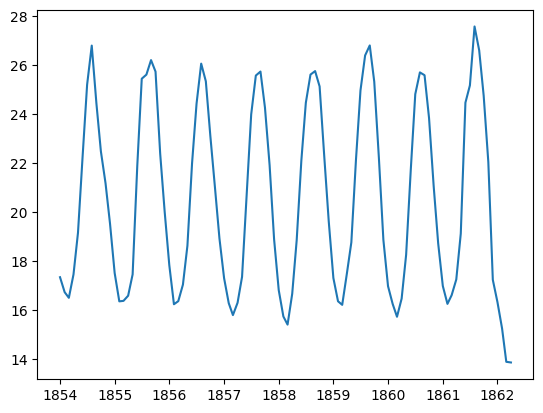

In [20]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = df_sst_lat_lon.index.tolist()
plt.plot(index[:100],df_sst_lat_lon['sst'][:100])
plt.show()

### Criando os datasets de treino e teste

In [21]:
# separa em treino e teste
X = df_sst_lat_lon['sst'].to_frame()
#X = df.columns.get_indexer(['sst'])
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

train.head()

Training data shape:  (1630, 1)
Test data shape:  (408, 1)


,sst
time,
1854-01-01,17.333422
1854-02-01,16.721617
1854-03-01,16.491089
1854-04-01,17.444820
1854-05-01,19.150229


In [22]:
# fazendo o pandas inferir a frequencia do índice #MS=month start frequency para esse dataset
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)
train.index 

DatetimeIndex(['1854-01-01', '1854-02-01', '1854-03-01', '1854-04-01',
               '1854-05-01', '1854-06-01', '1854-07-01', '1854-08-01',
               '1854-09-01', '1854-10-01',
               ...
               '1989-01-01', '1989-02-01', '1989-03-01', '1989-04-01',
               '1989-05-01', '1989-06-01', '1989-07-01', '1989-08-01',
               '1989-09-01', '1989-10-01'],
              dtype='datetime64[ns]', length=1630, freq='MS')

### Implementando o ARIMA/SARIMA

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using the statsmodels library. In the next section, we perform the following steps:

    Define the model by calling SARIMAX() and passing in the model parameters: p, d, and q parameters, and P, D, and Q parameters.
    The model is prepared on the training data by calling the fit() function.
    Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:

    p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
    d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
    q is the parameter associated with the moving average part of the model.

If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P, D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.


### Otimizando os parâmetros para o SARIMA

In [23]:
# https://alkaline-ml.com/pmdarima/
import pmdarima as pm

# referênica 
# https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

# Procura pelos melhores parâmetros (order e seasonal_order)
#Even after differencing the data by 24 hours (the seasonal frequency), we still see a seasonal trend in the data.
#Selecting the best parameters for an Arima model can be challenging - somewhat subjective and time intesive, 
#so we'll leave it as an exercise to the user. We used an auto_arima() function to search a provided space of 
#parameters for the best model.
auto_tune = True

if (auto_tune):
    auto_model = pm.auto_arima(train, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=2.78 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=4027.614, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=3578.288, Time=0.85 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=inf, Time=2.17 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=3909.220, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=3395.225, Time=2.39 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=8.85 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=3511.643, Time=1.51 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=3343.856, Time=3.04 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=3524.215, Time=1.19 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=12.77 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=5.52 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=3274.447, Time=3.47 sec
 ARIMA(3,1,0)(1,1,0)[24]             : AIC=3440.

### Treinando o modelo com o dataset de treino

Aqui depois de obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior

In [24]:
# parâmetro obtidos do otimizador auto_arima
order = (5, 1, 0)
seasonal_order = (2, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                sst   No. Observations:                 1630
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 24)   Log Likelihood               -1608.423
Date:                            Thu, 23 Nov 2023   AIC                           3232.846
Time:                                    21:23:15   BIC                           3275.893
Sample:                                01-01-1854   HQIC                          3248.828
                                     - 10-01-1989                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3925      0.017    -23.048      0.000      -0.426      -0.359
ar.L2         -0.3063      0.019   

### Plotando a distribuição dos erros resíduais

Média zero nos resíduos indica que não há viéis na predição.

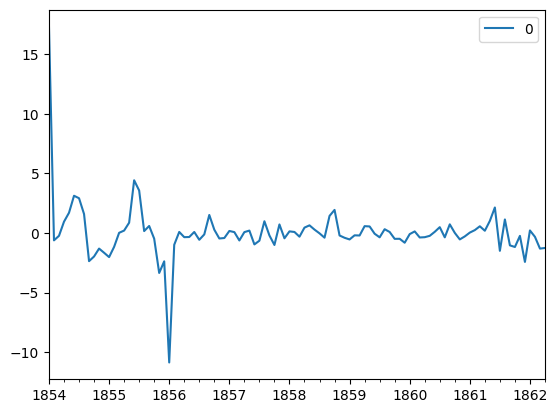

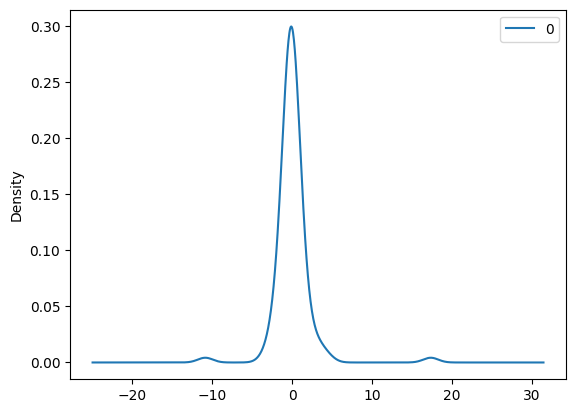

                0
count  100.000000
mean     0.041000
std      2.366451
min    -10.858666
25%     -0.497215
50%     -0.100476
75%      0.356598
max     17.333422


In [25]:
# plot residual errors
residuals = pd.DataFrame(results.resid[0:100])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

###  Treinando o modelo

Será realizada uma **walk-forward validation** que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


##### Definindo o horizonte em meses para a predição

In [30]:
HORIZONTE = 5 #numero de meses à frente para prever
test_shifted = test.copy()

for t in range(1, HORIZONTE):
    test_shifted['sst+'+str(t)] = test_shifted['sst'].shift(-t, freq='MS')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.tail(5)

,sst,sst+1,sst+2,sst+3,sst+4
2023-02-01,17.399174,17.524534,17.822731,19.385254,23.629042
2023-03-01,17.524534,17.822731,19.385254,23.629042,27.487192
2023-04-01,17.822731,19.385254,23.629042,27.487192,28.331211
2023-05-01,19.385254,23.629042,27.487192,28.331211,27.635229
2023-06-01,23.629042,27.487192,28.331211,27.635229,26.480513


#### Criando os datasets de acordo com a janela de treinamento

In [42]:
training_window = 96 # meses de janela de treino (8 anos) 

train_ts = train['sst']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):] #da data atual para anterior

#print(history)
#print(train['sst'])
#train_ts.head()

### Treino dos modelos para as janelas com os parâmetros otimizados

In [45]:
%%time
predictions = list()
for t in range(test_ts.shape[0]):
    #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZONTE)
    
    yhat = np.round(yhat,decimals = 2)
    predictions.append(yhat)
    
    observation = list(test_ts.iloc[t])
    observation = np.round(observation,decimals = 2)
    
    # move the training window
    history.append(observation[0])
    history.pop(0)
    
    print(t+1, '. Predicting time step: ', test_ts.index[t])
    print(t+1, ': predicted =', yhat)
    print(t+1, ': expected  =', observation)
    print('----------')

1 . Predicting time step:  1989-11-01 00:00:00
1 : predicted = [19.38 17.41 16.97 18.22 20.08]
1 : expected  = [21.3  19.29 17.55 16.96 16.88]
----------
2 . Predicting time step:  1989-12-01 00:00:00
2 : predicted = [19.89 18.73 19.07 21.03 23.92]
2 : expected  = [19.29 17.55 16.96 16.88 17.28]
----------
3 . Predicting time step:  1990-01-01 00:00:00
3 : predicted = [17.89 18.42 20.75 23.7  27.19]
3 : expected  = [17.55 16.96 16.88 17.28 19.33]
----------
4 . Predicting time step:  1990-02-01 00:00:00
4 : predicted = [18.06 20.6  23.69 27.08 28.72]
4 : expected  = [16.96 16.88 17.28 19.33 22.26]
----------
5 . Predicting time step:  1990-03-01 00:00:00
5 : predicted = [18.96 22.47 26.78 28.76 28.05]
5 : expected  = [16.88 17.28 19.33 22.26 25.1 ]
----------
6 . Predicting time step:  1990-04-01 00:00:00
6 : predicted = [19.39 24.44 27.92 28.22 26.7 ]
6 : expected  = [17.28 19.33 22.26 25.1  26.47]
----------
7 . Predicting time step:  1990-05-01 00:00:00
7 : predicted = [20.8  24.09 

54 . Predicting time step:  1994-04-01 00:00:00
54 : predicted = [17.91 20.7  23.58 26.4  28.07]
54 : expected  = [17.17 19.36 22.21 25.74 27.84]
----------
55 . Predicting time step:  1994-05-01 00:00:00
55 : predicted = [19.27 21.99 25.16 27.26 26.53]
55 : expected  = [19.36 22.21 25.74 27.84 27.33]
----------
56 . Predicting time step:  1994-06-01 00:00:00
56 : predicted = [22.14 25.33 27.38 26.6  24.98]
56 : expected  = [22.21 25.74 27.84 27.33 25.2 ]
----------
57 . Predicting time step:  1994-07-01 00:00:00
57 : predicted = [25.46 27.55 26.77 25.14 22.55]
57 : expected  = [25.74 27.84 27.33 25.2  21.91]
----------
58 . Predicting time step:  1994-08-01 00:00:00
58 : predicted = [28.04 27.33 25.59 22.91 19.78]
58 : expected  = [27.84 27.33 25.2  21.91 18.97]
----------
59 . Predicting time step:  1994-09-01 00:00:00
59 : predicted = [26.88 24.96 22.3  19.31 17.31]
59 : expected  = [27.33 25.2  21.91 18.97 17.  ]
----------
60 . Predicting time step:  1994-10-01 00:00:00
60 : predi

107 . Predicting time step:  1998-09-01 00:00:00
107 : predicted = [26.61 24.23 21.54 18.98 17.28]
107 : expected  = [25.93 24.2  21.93 19.01 17.18]
----------
108 . Predicting time step:  1998-10-01 00:00:00
108 : predicted = [23.76 21.23 18.79 17.04 16.4 ]
108 : expected  = [24.2  21.93 19.01 17.18 16.17]
----------
109 . Predicting time step:  1998-11-01 00:00:00
109 : predicted = [21.55 18.95 17.1  16.55 16.37]
109 : expected  = [21.93 19.01 17.18 16.17 16.72]
----------
110 . Predicting time step:  1998-12-01 00:00:00
110 : predicted = [19.25 17.25 16.61 16.43 16.7 ]
110 : expected  = [19.01 17.18 16.17 16.72 17.06]
----------
111 . Predicting time step:  1999-01-01 00:00:00
111 : predicted = [17.01 16.52 16.48 16.66 18.93]
111 : expected  = [17.18 16.17 16.72 17.06 19.49]
----------
112 . Predicting time step:  1999-02-01 00:00:00
112 : predicted = [16.61 16.54 16.7  18.98 22.6 ]
112 : expected  = [16.17 16.72 17.06 19.49 23.19]
----------
113 . Predicting time step:  1999-03-01 

159 . Predicting time step:  2003-01-01 00:00:00
159 : predicted = [17.66 16.96 16.96 17.26 19.72]
159 : expected  = [17.6  16.36 16.12 16.81 20.15]
----------
160 . Predicting time step:  2003-02-01 00:00:00
160 : predicted = [16.9  16.93 17.25 19.7  23.28]
160 : expected  = [16.36 16.12 16.81 20.15 23.89]
----------
161 . Predicting time step:  2003-03-01 00:00:00
161 : predicted = [16.54 17.13 19.64 23.17 25.28]
161 : expected  = [16.12 16.81 20.15 23.89 27.31]
----------
162 . Predicting time step:  2003-04-01 00:00:00
162 : predicted = [16.81 19.55 23.1  25.14 27.01]
162 : expected  = [16.81 20.15 23.89 27.31 28.69]
----------
163 . Predicting time step:  2003-05-01 00:00:00
163 : predicted = [19.55 23.11 25.15 27.01 26.42]
163 : expected  = [20.15 23.89 27.31 28.69 26.73]
----------
164 . Predicting time step:  2003-06-01 00:00:00
164 : predicted = [23.66 25.29 27.11 26.64 25.08]
164 : expected  = [23.89 27.31 28.69 26.73 25.03]
----------
165 . Predicting time step:  2003-07-01 

211 . Predicting time step:  2007-05-01 00:00:00
211 : predicted = [20.18 23.5  26.74 28.01 27.04]
211 : expected  = [19.95 23.08 26.05 27.39 26.66]
----------
212 . Predicting time step:  2007-06-01 00:00:00
212 : predicted = [23.28 26.55 27.82 26.96 25.53]
212 : expected  = [23.08 26.05 27.39 26.66 24.71]
----------
213 . Predicting time step:  2007-07-01 00:00:00
213 : predicted = [26.38 27.67 26.83 25.47 22.57]
213 : expected  = [26.05 27.39 26.66 24.71 21.5 ]
----------
214 . Predicting time step:  2007-08-01 00:00:00
214 : predicted = [27.47 26.58 25.28 22.45 19.48]
214 : expected  = [27.39 26.66 24.71 21.5  18.64]
----------
215 . Predicting time step:  2007-09-01 00:00:00
215 : predicted = [26.47 25.15 22.34 19.39 17.17]
215 : expected  = [26.66 24.71 21.5  18.64 17.28]
----------
216 . Predicting time step:  2007-10-01 00:00:00
216 : predicted = [25.3  22.48 19.52 17.26 16.69]
216 : expected  = [24.71 21.5  18.64 17.28 16.46]
----------
217 . Predicting time step:  2007-11-01 

263 . Predicting time step:  2011-09-01 00:00:00
263 : predicted = [26.8  24.85 21.67 18.85 17.13]
263 : expected  = [27.42 24.52 21.97 19.88 17.78]
----------
264 . Predicting time step:  2011-10-01 00:00:00
264 : predicted = [25.35 22.13 19.25 17.28 16.62]
264 : expected  = [24.52 21.97 19.88 17.78 16.4 ]
----------
265 . Predicting time step:  2011-11-01 00:00:00
265 : predicted = [21.52 18.8  16.98 16.49 16.55]
265 : expected  = [21.97 19.88 17.78 16.4  16.53]
----------
266 . Predicting time step:  2011-12-01 00:00:00
266 : predicted = [19.   17.17 16.62 16.65 17.51]
266 : expected  = [19.88 17.78 16.4  16.53 17.46]
----------
267 . Predicting time step:  2012-01-01 00:00:00
267 : predicted = [17.68 17.11 17.   17.73 20.3 ]
267 : expected  = [17.78 16.4  16.53 17.46 19.83]
----------
268 . Predicting time step:  2012-02-01 00:00:00
268 : predicted = [17.15 17.04 17.78 20.29 23.22]
268 : expected  = [16.4  16.53 17.46 19.83 23.79]
----------
269 . Predicting time step:  2012-03-01 

315 . Predicting time step:  2016-01-01 00:00:00
315 : predicted = [18.14 17.28 17.29 18.33 20.18]
315 : expected  = [18.27 17.44 17.43 18.44 19.61]
----------
316 . Predicting time step:  2016-02-01 00:00:00
316 : predicted = [17.35 17.37 18.41 20.24 23.28]
316 : expected  = [17.44 17.43 18.44 19.61 23.16]
----------
317 . Predicting time step:  2016-03-01 00:00:00
317 : predicted = [17.43 18.47 20.28 23.29 26.66]
317 : expected  = [17.43 18.44 19.61 23.16 25.8 ]
----------
318 . Predicting time step:  2016-04-01 00:00:00
318 : predicted = [18.47 20.28 23.29 26.66 27.88]
318 : expected  = [18.44 19.61 23.16 25.8  27.12]
----------
319 . Predicting time step:  2016-05-01 00:00:00
319 : predicted = [20.24 23.25 26.62 27.84 27.35]
319 : expected  = [19.61 23.16 25.8  27.12 27.22]
----------
320 . Predicting time step:  2016-06-01 00:00:00
320 : predicted = [22.95 26.21 27.47 27.2  25.51]
320 : expected  = [23.16 25.8  27.12 27.22 25.7 ]
----------
321 . Predicting time step:  2016-07-01 

367 . Predicting time step:  2020-05-01 00:00:00
367 : predicted = [19.56 23.6  26.2  27.84 27.69]
367 : expected  = [20.27 23.04 26.45 28.49 28.24]
----------
368 . Predicting time step:  2020-06-01 00:00:00
368 : predicted = [24.36 26.77 28.51 28.22 25.62]
368 : expected  = [23.04 26.45 28.49 28.24 25.59]
----------
369 . Predicting time step:  2020-07-01 00:00:00
369 : predicted = [25.54 27.49 27.04 24.8  22.47]
369 : expected  = [26.45 28.49 28.24 25.59 22.76]
----------
370 . Predicting time step:  2020-08-01 00:00:00
370 : predicted = [28.16 27.7  25.5  22.99 19.99]
370 : expected  = [28.49 28.24 25.59 22.76 20.07]
----------
371 . Predicting time step:  2020-09-01 00:00:00
371 : predicted = [28.03 25.75 23.25 20.22 17.83]
371 : expected  = [28.24 25.59 22.76 20.07 18.25]
----------
372 . Predicting time step:  2020-10-01 00:00:00
372 : predicted = [25.91 23.38 20.36 17.93 17.11]
372 : expected  = [25.59 22.76 20.07 18.25 17.42]
----------
373 . Predicting time step:  2020-11-01 

In [46]:
eval_df = pd.DataFrame(predictions, columns=['sst+'+str(t) for t in range(1, HORIZONTE+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZONTE+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['atual'] = np.array(np.transpose(test_ts)).ravel()
eval_df.head(1250)

,timestamp,h,prediction,atual
0,1989-11-01,sst+1,19.38,21.295662
1,1989-12-01,sst+1,19.89,19.291939
2,1990-01-01,sst+1,17.89,17.547276
3,1990-02-01,sst+1,18.06,16.955896
4,1990-03-01,sst+1,18.96,16.877939
...,...,...,...,...
1245,1992-08-01,sst+4,20.97,21.926542
1246,1992-09-01,sst+4,19.01,19.066292
1247,1992-10-01,sst+4,15.35,16.940664
1248,1992-11-01,sst+4,15.43,16.115524


#### Computando o MAPE: Mean Absolute Percentage Error sobre todas as predições

O erro percentual absoluto médio ([MAPE](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334)) é uma medida de erro relativo que usa valores absolutos para impedir que os erros positivos e negativos cancelem uns aos outros e usa erros relativos para permitir que você compare a precisão da previsão entre métodos de série temporais.

$MAPE = \frac{1}{n} \sum_{t=1}^{n} |\frac{A_t - F_t}{A_t}|$ $->$ MAPE = Média de (abs((Atual - Forecast)/(Atual))



In [47]:
if(HORIZONTE > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['atual']).abs() / eval_df['atual']
    print(eval_df.groupby('h')['APE'].mean())

h
sst+1    0.020959
sst+2    0.032805
sst+3    0.038129
sst+4    0.040374
sst+5    0.038389
Name: APE, dtype: float64


MAPE quanto menor o valor, melhor

In [48]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 'sst+1']['prediction'], eval_df[eval_df['h'] == 'sst+1']['atual']))*100, '%')

One step forecast MAPE:  2.0958915049850266 %


In [49]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['atual'])*100, '%')

Multi-step forecast MAPE:  3.4131197389682977 %


### Plotando as predições Versus valor atual para os cinco primeiros meses (t+1,...,t+5)

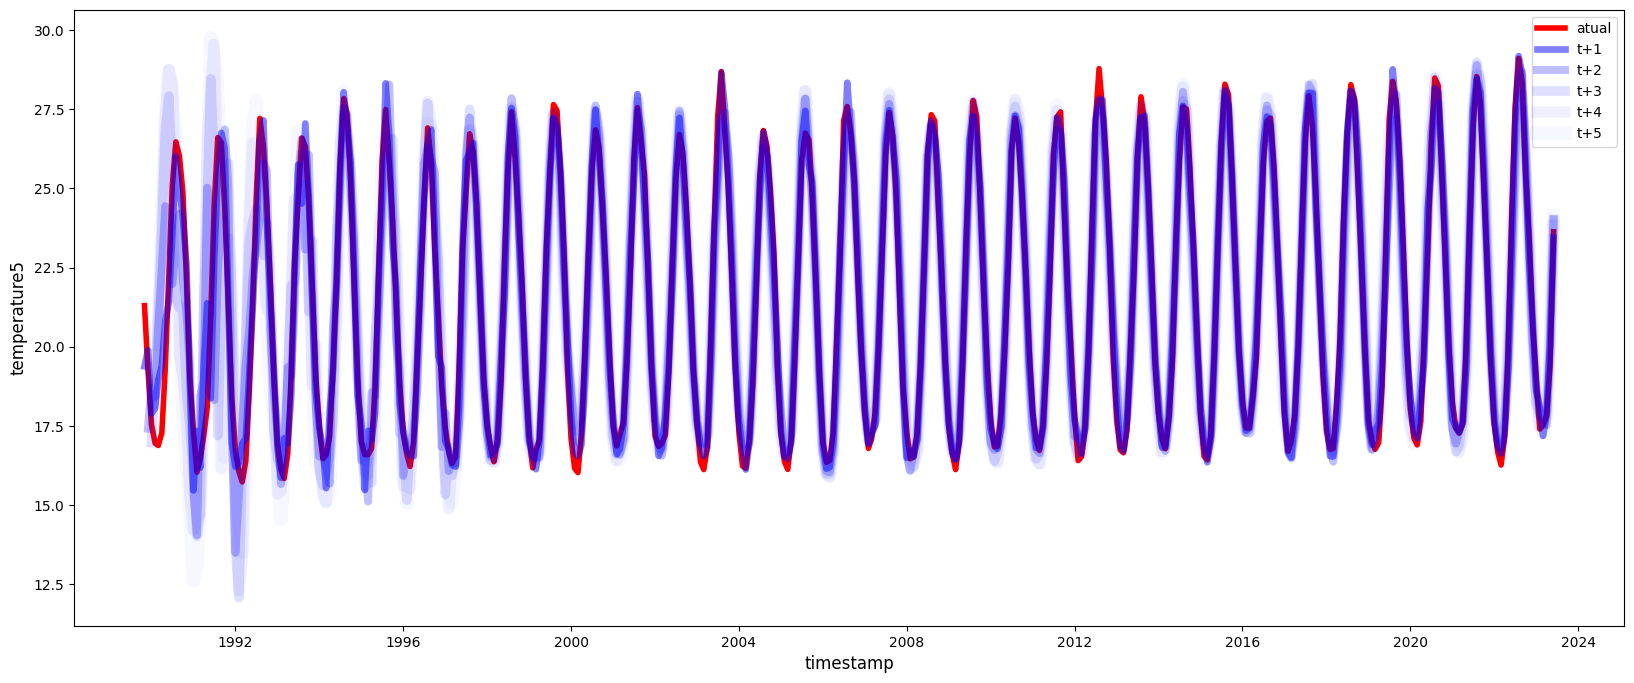

In [50]:
## Plotting multi step forecast
plot_df = eval_df[(eval_df.h=='sst+1')][['timestamp', 'atual']]
for t in range(1, HORIZONTE+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.h=='sst+'+str(t))]['prediction'].values

plot_df.head()
fig = plt.figure(figsize=(20, 8))
plt.plot(plot_df['timestamp'], plot_df['atual'], color='red', linewidth=4.0, label='atual')

for t in range(1, HORIZONTE+1):
    x = plot_df['timestamp'][(t-1):]
    y = plot_df['t+'+str(t)][0:len(x)]
    plt.plot(x, y, color='blue', linewidth=4*math.pow(1.2,t), alpha=math.pow(0.5,t), label='t+'+str(t))

plt.legend()
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('temperature'+str(t), fontsize=12)
plt.show()

### Algumas informações sobre o modelo treinado para SST

In [51]:
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0308      0.130     -0.236      0.813      -0.287       0.225
ar.L2         -0.1742      0.146     -1.190      0.234      -0.461       0.113
ar.L3         -0.1924      0.120     -1.597      0.110      -0.429       0.044
ar.L4         -0.1235      0.160     -0.771      0.441      -0.438       0.191
ar.L5         -0.0673      0.139     -0.483      0.629      -0.341       0.206
ar.S.L24      -0.5283      0.159     -3.329      0.001      -0.839      -0.217
ar.S.L48      -0.0543      0.325     -0.167      0.867      -0.691       0.582
sigma2         0.1763      0.037      4.799      0.000       0.104       0.248


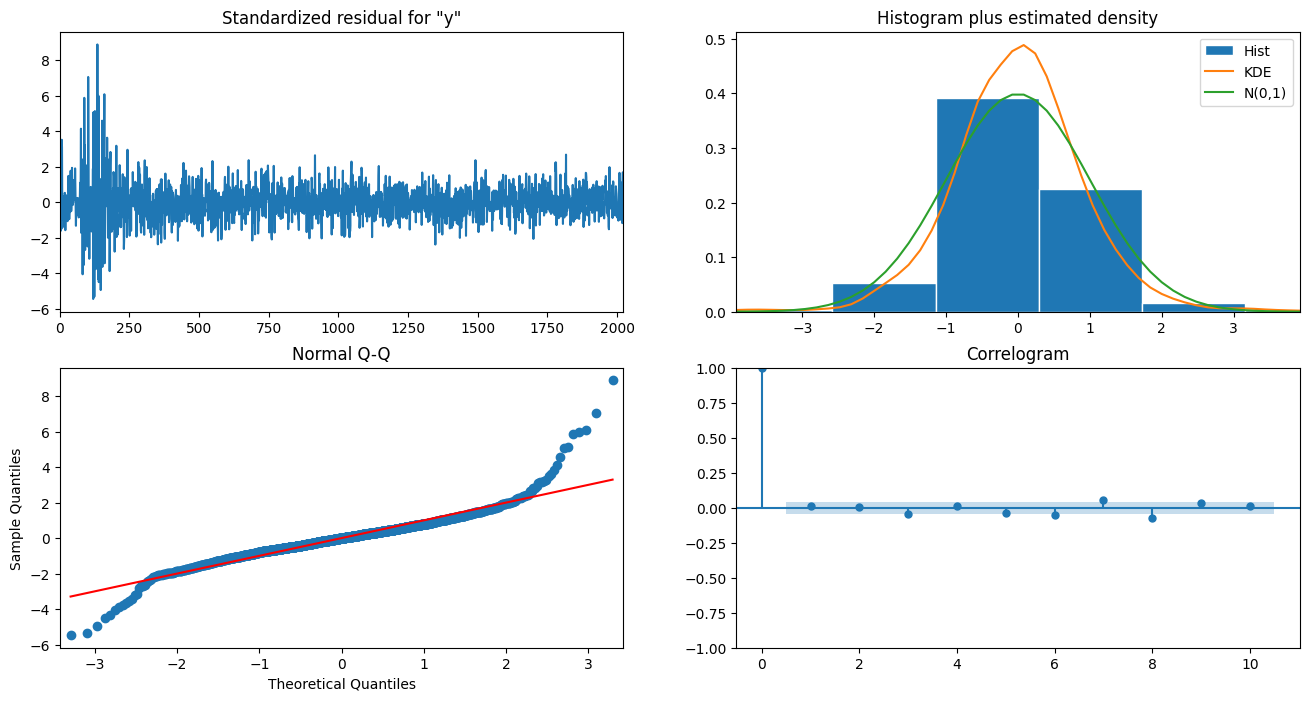

In [40]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Referências

Este projeto é uma adaptação das seguintes referências:

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima

